In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# 1. Generative Models for Text
We are trying to mimic the writing style of prominent British writer Bertrand Russell

## b) Data Description
##### Main Corpus:
1. The Problems of Philosophy
2. The Analysis of Mind
3. Mysticism and Logic and Other Essays
4. Our Knowledge of the External World as a Field for Scientific Method in Philosophy

##### Supplementary Corpus:
1. The History of Western Philosophy
2. The Analysis of Matter
3. An Inquiry into Meaning and Truth

## c) LSTM

### i & ii. Create a corpus using character-level representation (Extended ASCII n = 256)

In [9]:
# TPP.txt
# TAM.txt
# MLOE.txt
# OKEWFSMP.txt
# ---- MAIN CORPUS ----
tpp = open('../data/books/TPP.txt', 'r', errors='ignore', encoding='utf-8-sig').read()
tpp = re.sub(r'[^\w\s]', '', tpp).lower()
tpp_ascii = [ord(i) for i in tpp]

tam = open('../data/books/TAM.txt', 'r', errors='ignore', encoding='utf-8-sig').read()
tam = re.sub(r'[^\w\s]', '', tam).lower()
tam_ascii = [ord(i) for i in tam]

mloe = open('../data/books/MLOE.txt', 'r', errors='ignore', encoding='utf-8-sig').read()
mloe = re.sub(r'[^\w\s]', '', mloe).lower()
mloe_ascii = [ord(i) for i in mloe]

oke = open('../data/books/OKEWFSMP.txt', 'r', errors='ignore', encoding='utf-8-sig').read()
oke = re.sub(r'[^\w\s]', '', oke).lower()
oke_ascii = [ord(i) for i in oke]

corpus = np.concatenate((tpp_ascii, tam_ascii, mloe_ascii, 
                         oke_ascii), axis=None)
corpus = [i if i < 255 else 0 for i in corpus]

dic = {} # {original ASCII: index}
dic_reverse = {} # {index: original ASCII}
for i, x in enumerate(np.unique(corpus)):
    dic[x] = i
    dic_reverse[i] = x

num_unique = len(dic)
corpus_abbr = np.array([dic.get(i, i) for i in corpus])


# Normalizing to accomodate LSTM's softmax function
corpus_abbr_norm = corpus_abbr/np.linalg.norm(corpus_abbr, 
                                ord=np.inf, axis=0, keepdims=True)


### iii-x. Building the LSTM
1. Window size: W = 100
2. Inputs to the network: W-1 characters, output: the Wth character
3. On-hot encoding for the output (in this case, 50)
4. Single hidden layer for the LSTM with N=51 memory units
5. Softmax output layer for a prediction for each of the 51 classes
6. Log loss (cross entropy) as the objective function
7. Determine the number of epochs for training (30)
8. Checkpoint to save the model weights for each epoch

**Reshaping input to be a 3D array (__, 99, 1)**

In [30]:
start = 0
end = 99
train_X = list([[[i] for i in corpus_abbr_norm[start:end]]])
train_y = [int(corpus_abbr_norm[end]*50)]
while end < corpus_abbr_norm.size - 2:
    start += 1
    end += 1
    train_X.append([[i] for i in corpus_abbr_norm[start:end]])
    train_y.append(int(corpus_abbr_norm[end]*50))

In [31]:
train_X = tf.convert_to_tensor(train_X)
# One-hot encoding
train_y = to_categorical(train_y, num_classes=num_unique)

**Initializing LSTM Model**

In [32]:
def create_model():
    model = Sequential([
    layers.LSTM(units=num_unique, input_shape=(99, 1)),
    layers.Dense(units=num_unique, activation='softmax'),
    ])

    model.summary()

    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

    return model

**Checkpointing to save the model, and running it**

**NOTE**: I've only run the following cell with a small training set to see if it works. I was checking to see if there were compatibility issues with Google Colab.

In [33]:
checkpoint_path = "../model_weights/training_1/cp-{epoch:04d}.ckpt"

batch_size = 1024

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(train_X, train_y, batch_size=1024, epochs=30, verbose=1, callbacks=[cp_callback])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 51)                10812     
_________________________________________________________________
dense_5 (Dense)              (None, 51)                2652      
Total params: 13,464
Trainable params: 13,464
Non-trainable params: 0
_________________________________________________________________
Train on 22 samples
Epoch 1/30

Epoch 00001: saving model to ../model_weights/training_0/cp-0001.ckpt
22/22 [==============================] - 1s 54ms/sample - loss: 3.9389 - accuracy: 0.0909
Epoch 2/30

Epoch 00002: saving model to ../model_weights/training_0/cp-0002.ckpt
22/22 [==============================] - 0s 2ms/sample - loss: 3.9283 - accuracy: 0.0909
Epoch 3/30

Epoch 00003: saving model to ../model_weights/training_0/cp-0003.ckpt
22/22 [==============================] - 0s 2ms/sample - loss: 3.91

## NOTE on Running LSTM on Jupyter Notebook
I ran the code to completion on Google Colab (GPU) for faster execution. Since I saved the model, I will be loading the weights from the file path: ../model_weights/training_1

In [15]:
model = create_model()
model.load_weights('../model_weights/training_1/cp-0030.ckpt')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 51)                10812     
_________________________________________________________________
dense_3 (Dense)              (None, 51)                2652      
Total params: 13,464
Trainable params: 13,464
Non-trainable params: 0
_________________________________________________________________
../model_weights/training_1/cp-0030.ckpt

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a95ebca90> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1aaea74050>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1aaea78310> and <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a95ebca90>).


### xi. Generating 1000 characters from a short text

**Analysis**: It's clear that the simple model does not do a great job in predicting future text. It seems to repeat the same words multiple times. See xii for a more comprehensive model.

In [21]:
test = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object'
test = re.sub(r'[^\w\s]', '', test).lower()
test = [dic[ord(i)]/50.0 for i in test] # because we are rescaling 0-50

**Reshaping test set to fit the model**

In [22]:
start = 0
end = 99
test_X = list([[[i] for i in test[start:end]]])
test_y = [test[end]]
while end < len(test) - 2:
    start += 1
    end += 1
    test_X.append([[i] for i in test[start:end]])
    test_y.append(test[end])

**Prediction**

In [23]:
predicted_string = ''
for i in range(1000):
    buffer_testX = tf.convert_to_tensor([test_X[-1]])
    prediction = model.predict(buffer_testX)
    prediction = np.argmax(prediction[0])
    buffer = test_X[-1]
    buffer.pop(0)
    buffer.append([prediction/50])
    test_X.append(buffer)
    pred_char = chr(dic_reverse[prediction])
    predicted_string += pred_char

In [24]:
final_string = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.'
final_string = re.sub(r'[^\w\s]', '', final_string).lower()
print(final_string + predicted_string)

there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to emphasize the object the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the oaje the

### xii. Investigation to Improve the Model
I implemented a model with an extra LSTM layer and ran it for 100 epochs. The results were slightly more diverse, but it was nonetheless underwhelming

In [25]:
def create_model_2():
    model = Sequential([
    layers.LSTM(units=num_unique, input_shape=(99, 1), return_sequences=True),
    layers.LSTM(units=num_unique),
    layers.Dense(units=num_unique, activation='softmax'),
    ])

    model.summary()

    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

    return model

In [ ]:
checkpoint_path = "../model_weights/training_2/cp-{epoch:04d}.ckpt"

batch_size = 1024

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

model2 = create_model_2()

model2.save_weights(checkpoint_path.format(epoch=0))

model2.fit(train_X, train_y, batch_size=1024, epochs=100, verbose=1, callbacks=[cp_callback])

Open the saved weights from Google Colab

In [26]:
model2 = create_model_2()
model2.load_weights('../model_weights/training_2/cp-0100.ckpt')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 99, 51)            10812     
_________________________________________________________________
lstm_5 (LSTM)                (None, 51)                21012     
_________________________________________________________________
dense_4 (Dense)              (None, 51)                2652      
Total params: 34,476
Trainable params: 34,476
Non-trainable params: 0
_________________________________________________________________

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1bb30ccd90> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1ad47af510>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1e2d0d6f50> and <tensorflow.python.keras.la

Predicting output like xi

In [27]:
start = 0
end = 99
test_X = list([[[i] for i in test[start:end]]])
test_y = [test[end]]
while end < len(test) - 2:
    start += 1
    end += 1
    test_X.append([[i] for i in test[start:end]])
    test_y.append(test[end])

In [28]:
predicted_string = ''
for i in range(500):
    buffer_testX = tf.convert_to_tensor([test_X[-1]])
    prediction = model2.predict(buffer_testX)
    prediction = np.argmax(prediction[0])
    buffer = test_X[-1]
    buffer.pop(0)
    buffer.append([prediction/50])
    test_X.append(buffer)
    pred_char = chr(dic_reverse[prediction])
    predicted_string += pred_char

In [29]:
final_string = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.'
final_string = re.sub(r'[^\w\s]', '', final_string).lower()
print(final_string + predicted_string)

there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to emphasize the objectct of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of the our of


# 2. Deep CNNs for Image Colorization
## b) Extract only birds class
From the data, the label is x=2

In [160]:
import pickle
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from skimage.color import rgb2gray
from tensorflow.keras.utils import to_categorical

In [4]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [10]:
df = pd.DataFrame({})
file_list = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
file_path = '../data/cnn/'
for i in file_list:
    o = unpickle(file_path + i)
    ind = [i for i, x in enumerate(o[b'labels']) if x == 2]
    df_buffer = pd.DataFrame(o[b'data'][ind, :])
    df = df.append(df_buffer, ignore_index=True)

In [12]:
stack = []
start = 0
end = 1024
for i in range(3):
    stack.append(df.iloc[:, start:end].to_numpy())
    start += 1024
    end += 1024

combined = np.stack((stack[0], stack[1], stack[2]))

(3, 6000, 1024)

## c) OPTIONAL: Subset at least 10% of the pixels
I did not implement this because I had time to run the k-means on the entire dataset

## d) Converting colored images to one centroid color
### i. K-Means clustering (k=4) to find centroids

In [17]:
flattened = combined.reshape(3, 6144000).transpose()
km = KMeans(n_clusters=4)
#km.fit(flattened)
#print(km.cluster_centers_)

centroids = np.array([[108.31595582, 108.00547268,  82.22536204],
 [206.19234899, 211.45954195, 211.09803978],
 [155.84194302, 155.08648076, 134.84745145],
 [ 48.59795602,  49.58179859,  38.23920815]])

centroids = np.round(centroids)
print(centroids)

[[108. 108.  82.]
 [206. 211. 211.]
 [156. 155. 135.]
 [ 49.  50.  38.]]


### ii. Converting colored images to k-color images (k=4)
Output: The actual k-color image
One_hot: The argmin of the color with the centroid (for each pixel). This variable will be used for one-hot encoding later in part f)

In [225]:
test = combined.transpose()
output = np.zeros(shape=(6000, 1024, 3))
one_hot = np.zeros(shape=(6000, 1024))

for i in range(6000):
    distances = cdist(test[:, i, :], centroids, 'euclidean')
    for j in range(1024):
        min_distance = np.argmin(distances[j])
        output[i, j, :] = centroids[min_distance]
        one_hot[i, j] = min_distance

## e) Converting original image to grayscale

In [63]:
buffer = combined[:, 0, :].reshape(3, 32, 32).transpose()
gray = rgb2gray(buffer)
for i in range(1, 6000):
    buffer = combined[:, i, :].reshape(3, 32, 32).transpose()
    gray = np.dstack((gray, rgb2gray(buffer)))

(32, 32, 6000)

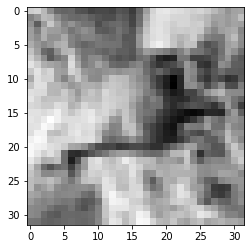

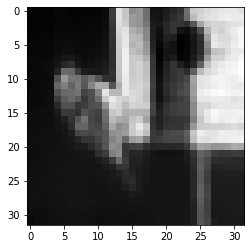

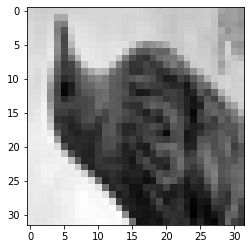

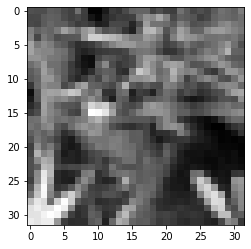

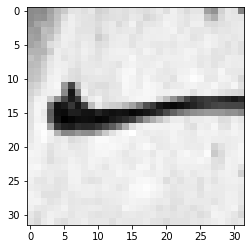

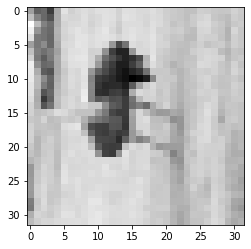

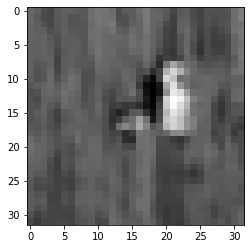

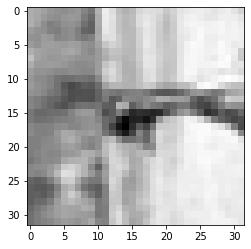

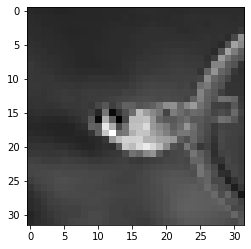

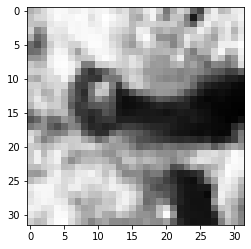

In [224]:
for i in range(10):
    plt.imshow(gray[:, :, i], cmap='gray')
    plt.show()

## f) Deep CNN Implementation

#### Note about train, test, and validation errors
I split the test data based on the original dataset (the last 1000 entries is the test set, while the other 5,000 are the training set). For best practices, I also trained the CNN using a validation set of 0.2 for each epoch. Essentially, the test set and validation set served the same purpose despite consisting of different data. This can be seen by the almost identical trendlines between the test error and validation error in the graph below.

### i. One-hot encoding

In [202]:
y = to_categorical(one_hot, num_classes=4)
y = y.reshape((6000, 32, 32, 4)).transpose((0, 2, 1, 3))

### ii. Constructing Neural Network

In [205]:
# Reshape input to better fit what tensorflow wants
inp = gray.transpose((2, 0, 1)).reshape(6000, 32, 32, 1)
train_X = tf.convert_to_tensor(inp[:5000, :, :, :])
train_y = tf.convert_to_tensor(y[:5000, :, :, :])
test_X = tf.convert_to_tensor(inp[5000:, :, :, :])
test_y = tf.convert_to_tensor(y[5000:, :, :, :])

**Components**:
1. Two convolution layers (5x5 filters)
2. One Max pooling layer
3. Two MLP layers
4. Softmax output layer

In [210]:
model = Sequential()

# 1. Two convolution layers with 5x5 filters
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))

# 2. Max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))

model.add(layers.Flatten())

# 3. 2 MLP layers
model.add(layers.Dense(units=1000, activation='relu'))
model.add(layers.Dense(units=4096, activation='linear'))

# 4. Softmax output. I reshaped it to look like the output shape first
model.add(layers.Reshape((32, 32, 4)))
model.add(layers.Softmax())
model.summary()

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # loss='categorical_crossentropy'

val_accuracy = []
train_accuracy = []
test_accuracy = []
for i in range(30):
    history = model.fit(train_X, train_y, batch_size=100, epochs=1, validation_split = 0.2, verbose=1)
    val_accuracy.append(history.history['val_accuracy'])
    train_accuracy.append(history.history['accuracy'])
    test_accuracy.append(model.evaluate(test_X, test_y)[1])

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_71 (Dense)             (None, 1000)              36865000  
_________________________________________________________________
dense_72 (Dense)             (None, 4096)              4100096   
_________________________________________________________________
reshape_13 (Reshape)         (None, 32, 32, 4)       

### iii. Visualization of Performance
#### a) Graph of Train, Test, and Validation Error for each Epoch

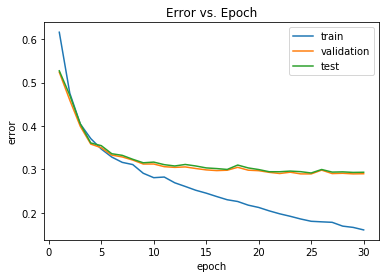

In [211]:
epochs = range(1, 31)
train = plt.plot(epochs, 1-np.array(train_accuracy), label='train')
val = plt.plot(epochs, 1-np.array(val_accuracy), label='validation')
test = plt.plot(epochs, 1-np.array(test_accuracy), label='test')
plt.title('Error vs. Epoch')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### b) Test, Train, and Validation Error at the final epoch

**Analysis**: As expected, the training error is much lower than the test/validation error because the model is tuned on the very same data.

In [217]:
print("Test Error: " + str(1-test_accuracy[-1]))
print("Train Error: " + str(1-train_accuracy[-1][0]))
print("Validation Error: " + str(1-val_accuracy[-1][0]))

Test Error: 0.2932109236717224
Train Error: 0.16033107042312622
Validation Error: 0.2897685766220093


### iv. Prediction and Comparison to the Original

In [215]:
prediction = model.predict(tf.convert_to_tensor(inp))

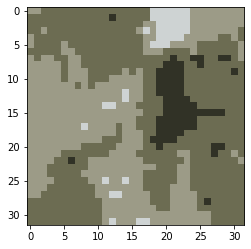

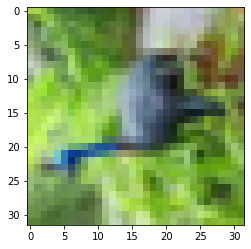

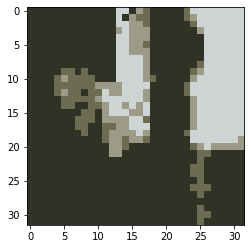

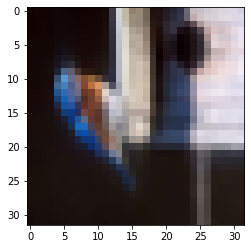

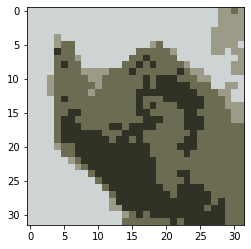

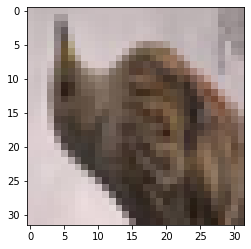

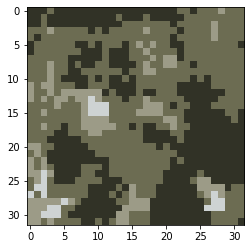

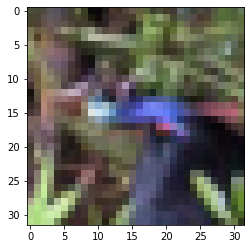

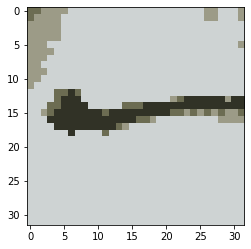

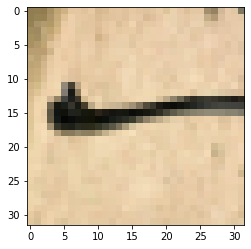

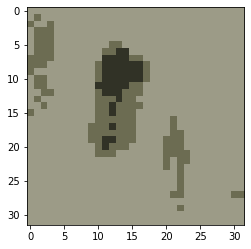

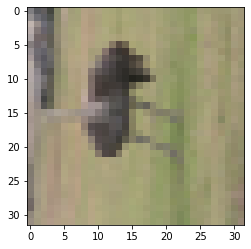

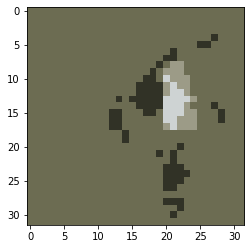

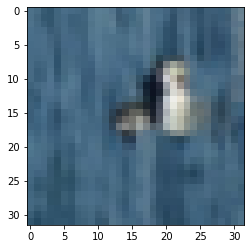

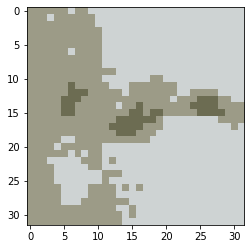

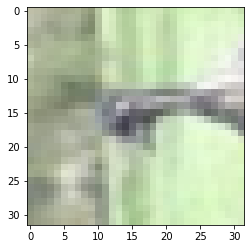

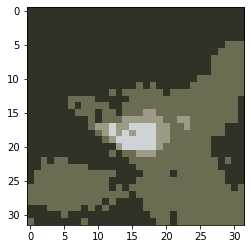

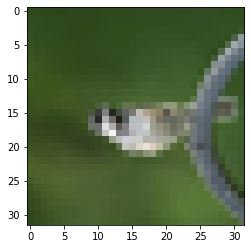

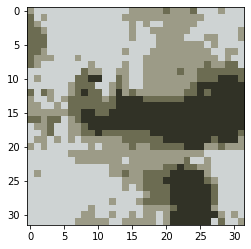

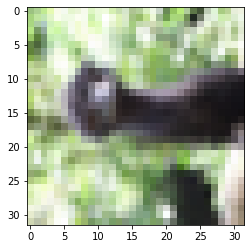

In [220]:
for i in range(10):
    estimation = np.zeros(shape=(32, 32, 3))
    for j in range(32):
        for k in range(32):
            estimation[j, k, :] = centroids[np.argmax(prediction[i, j, k, :])]
    estimation = np.uint8(estimation)
    plt.imshow(estimation)
    plt.show()
    
    real = combined[:, i, :].reshape(3, 32, 32).transpose((2, 1, 0))
    plt.imshow(real)
    plt.show()